# ResNet for CIFAR-10

You are going to implement [ResNet](https://arxiv.org/abs/1512.03385), one of the state-of-the-art CNN architecture.
Specifically, you are going to implement a variation of ResNet called [PreResNet](https://arxiv.org/abs/1603.05027), which locates activation before each convolutional layer (so called pre-activation).
You are going to first implement a plain building block, residual block, and then bottleneck block for really deep networks.
Finally, you will implement your own ResNet using those blocks.

Throughout this part, we will follow the PyTorch default weight initialization for conciseness.

## Install starter code
We will continue using the utility functions that we've used for previous assignments: [`coutils` package](https://github.com/deepvision-class/starter-code). Run this cell to download and install it.


In [ ]:
!pip install git+https://github.com/deepvision-class/starter-code

  Cloning https://github.com/deepvision-class/starter-code to /tmp/pip-req-build-zw1wmqwl
  Running command git clone -q https://github.com/deepvision-class/starter-code /tmp/pip-req-build-zw1wmqwl
  Created wheel for Colab-Utils: filename=Colab_Utils-0.1.dev0-py3-none-any.whl size=10307 sha256=9cfa5940e6de040f4dda13f4538d3a63e3913859ccda26afc7ff133ebc221f72
  Stored in directory: /tmp/pip-ephem-wheel-cache-rmtth0qz/wheels/eb/3c/88/465b0d78ef4a63d1f487c4208bd4691a448f05923eda0ef5f6
Successfully built Colab-Utils


## Setup code
Run some setup code for this notebook.

In [ ]:
import coutils
from coutils import fix_random_seed

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T

# for plotting
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [ ]:
NUM_TRAIN = 49000

# The torchvision.transforms package provides tools for preprocessing data
# and for performing data augmentation; here we set up a transform to
# preprocess the data by subtracting the mean RGB value and dividing by the
# standard deviation of each RGB value; we've hardcoded the mean and std.
transform = T.Compose([
                T.ToTensor(),
                T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
            ])

# We set up a Dataset object for each split (train / val / test); Datasets load
# training examples one at a time, so we wrap each Dataset in a DataLoader which
# iterates through the Dataset and forms minibatches. We divide the CIFAR-10
# training set into train and val sets by passing a Sampler object to the
# DataLoader telling how it should sample from the underlying Dataset.
cifar10_train = dset.CIFAR10('./datasets', train=True, download=True,
                             transform=transform)
loader_train = DataLoader(cifar10_train, batch_size=64, 
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

cifar10_val = dset.CIFAR10('./datasets', train=True, download=True,
                           transform=transform)
loader_val = DataLoader(cifar10_val, batch_size=64, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000)))

cifar10_test = dset.CIFAR10('./datasets', train=False, download=True, 
                            transform=transform)
loader_test = DataLoader(cifar10_test, batch_size=64)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./datasets/cifar-10-python.tar.gz to ./datasets
Files already downloaded and verified
Files already downloaded and verified


Note that if CUDA is not enabled, `torch.cuda.is_available()` will return False and this notebook will fallback to CPU mode.

The global variables `dtype` and `device` will control the data types throughout this assignment.

We will be using `torch.float = torch.float32` for data and `torch.long = torch.int64` for labels.

Please refer to https://pytorch.org/docs/stable/tensor_attributes.html#torch-dtype for more details about data types.

In [ ]:
dtype = torch.float
ltype = torch.long

if torch.cuda.is_available():
  device = torch.device('cuda:0')
else:
  device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)

using device: cuda:0


### Module API: Check Accuracy
Given the validation or test set, we can check the classification accuracy of a neural network. 

In [ ]:
def check_accuracy(loader, model):
  if loader.dataset.train:
    print('Checking accuracy on validation set')
  else:
    print('Checking accuracy on test set')   
  num_correct = 0
  num_samples = 0
  model.eval()  # set model to evaluation mode
  with torch.no_grad():
    for x, y in loader:
      x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
      y = y.to(device=device, dtype=ltype)
      scores = model(x)
      _, preds = scores.max(1)
      num_correct += (preds == y).sum()
      num_samples += preds.size(0)
    acc = float(num_correct) / num_samples
    print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
  return acc

### Module API: Training Loop
We also use a slightly different training loop. Rather than updating the values of the weights ourselves, we use an Optimizer object from the `torch.optim` package, which abstract the notion of an optimization algorithm and provides implementations of most of the algorithms commonly used to optimize neural networks.

In [ ]:
def adjust_learning_rate(optimizer, lrd, epoch, schedule):
  """
  Multiply lrd to the learning rate if epoch is in schedule
  
  Inputs:
  - optimizer: An Optimizer object we will use to train the model
  - lrd: learning rate decay; a factor multiplied at scheduled epochs
  - epochs: the current epoch number
  - schedule: the list of epochs that requires learning rate update
  
  Returns: Nothing, but learning rate might be updated
  """
  if epoch in schedule:
    for param_group in optimizer.param_groups:
      print('lr decay from {} to {}'.format(param_group['lr'], param_group['lr'] * lrd))
      param_group['lr'] *= lrd

def train(model, optimizer, epochs=1, learning_rate_decay=.1, schedule=[], verbose=True):
  """
  Train a model on CIFAR-10 using the PyTorch Module API.
  
  Inputs:
  - model: A PyTorch Module giving the model to train.
  - optimizer: An Optimizer object we will use to train the model
  - epochs: (Optional) A Python integer giving the number of epochs to train for
  
  Returns: Nothing, but prints model accuracies during training.
  """
  model = model.to(device=device)  # move the model parameters to CPU/GPU
  num_iters = epochs * len(loader_train)
  if verbose:
    num_prints = num_iters // print_every + 1
  else:
    num_prints = epochs
  acc_history = torch.zeros(num_prints, dtype=torch.float)
  iter_history = torch.zeros(num_prints, dtype=torch.long)
  for e in range(epochs):
    
    adjust_learning_rate(optimizer, learning_rate_decay, e, schedule)
    
    for t, (x, y) in enumerate(loader_train):
      model.train()  # put model to training mode
      x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
      y = y.to(device=device, dtype=ltype)

      scores = model(x)
      loss = F.cross_entropy(scores, y)

      # Zero out all of the gradients for the variables which the optimizer
      # will update.
      optimizer.zero_grad()

      # This is the backwards pass: compute the gradient of the loss with
      # respect to each  parameter of the model.
      loss.backward()

      # Actually update the parameters of the model using the gradients
      # computed by the backwards pass.
      optimizer.step()

      tt = t + e * len(loader_train)

      if verbose and (tt % print_every == 0 or (e == epochs-1 and t == len(loader_train)-1)):
        print('Epoch %d, Iteration %d, loss = %.4f' % (e, tt, loss.item()))
        acc = check_accuracy(loader_val, model)
        acc_history[tt // print_every] = acc
        iter_history[tt // print_every] = tt
        print()
      elif not verbose and (t == len(loader_train)-1):
        print('Epoch %d, Iteration %d, loss = %.4f' % (e, tt, loss.item()))
        acc = check_accuracy(loader_val, model)
        acc_history[e] = acc
        iter_history[e] = tt
        print()
  return acc_history, iter_history

## Plain block

First, let's implement a plain block without residual connection.
PreResNet has a different order of layers from the previously implemented ones;
BatchNorm and ReLU precedes Conv.
The name of PreResNet comes form this pre-activation architecture.
Here, for downsampling, we don't introduce MaxPool layers explicitly, but use stride 2 in the first Conv layer in the block.

Concretely, a plain block accepts a feature map of shape $C_{in} \times H_{in} \times W_{in}$ and produces a feature map of shape $C_{out} \times H_{out} \times W_{out}$. If the block performs downsampling, then $W_{out}=W_{in}/2$ and $H_{out}=H_{in}/2$; otherwise $H_{out}=H_{in}$ and $W_{out}=W_{in}$. The plain block consists of the following six layers in order:

1. Spatial Batch normalization
2. ReLU
3. Convolutional layer with `Cout` 3x3 filters, zero-padding of 1, and stride 2 if downsampling; otherwise stride 1
4. Spatial Batch normalization
5. ReLU
6. Convolutional layer with `Cout` 3x3 filters, with zero-padding of 1


In [ ]:
class PlainBlock(nn.Module):
  def __init__(self, Cin, Cout, downsample=False):
    super().__init__()

    self.net = None
    ############################################################################
    # TODO: Implement plain block.                                             #
    # Hint: Wrap your layers by nn.Sequential() to output a single module.     #
    #       You don't have use OrderedDict.                                    #
    # Inputs:                                                                  #
    # - Cin: number of input channels                                          #
    # - Cout: number of output channels                                        #
    # - downsample: add downsampling (a conv with stride=2) if True            #
    # Store the result in self.net.                                            #
    ############################################################################
    # Replace "pass" statement with your code
    if downsample:
        self.net = nn.Sequential(
            nn.BatchNorm2d(Cin),
            nn.ReLU(),
            nn.Conv2d(Cin, Cout, (3, 3), stride=2, padding=1),
            nn.BatchNorm2d(Cout),
            nn.ReLU(),
            nn.Conv2d(Cout, Cout, (3, 3), padding=1)
        )
    else:
        self.net = nn.Sequential(
            nn.BatchNorm2d(Cin),
            nn.ReLU(),
            nn.Conv2d(Cin, Cout, (3, 3), stride=1, padding=1),
            nn.BatchNorm2d(Cout),
            nn.ReLU(),
            nn.Conv2d(Cout, Cout, (3, 3), padding=1)
        )
    ############################################################################
    #                                 END OF YOUR CODE                         #
    ############################################################################

  def forward(self, x):
    return self.net(x)

In [ ]:
data = torch.zeros(2, 3, 5, 6)
model = PlainBlock(3, 10)
if list(model(data).shape) == [2, 10, 5, 6]:
  print('The output of PlainBlock without downsampling has a *correct* dimension!')
else:
  print('The output of PlainBlock without downsampling has an *incorrect* dimension! expected:', [2, 10, 5, 6], 'got:', list(model(data).shape))

data = torch.zeros(2, 3, 5, 6)
model = PlainBlock(3, 10, downsample=True)
if list(model(data).shape) == [2, 10, 3, 3]:
  print('The output of PlainBlock with downsampling has a *correct* dimension!')
else:
  print('The output of PlainBlock with downsampling has an *incorrect* dimension! expected:', [2, 10, 3, 3], 'got:', list(model(data).shape))

The output of PlainBlock without downsampling has a *correct* dimension!
The output of PlainBlock with downsampling has a *correct* dimension!


## Residual block

Next, let's implement a residual block.
A residual block adds a residual connection to a plain block. Let $\mathcal{F}$ be a plain block; then the residual version  $\mathcal{R}$ of the plain block $\mathcal{F}$ computes:

$\mathcal{R}(x) = \mathcal{F}(x) + x$

However, this implementation will only work if the output from the plain block $\mathcal{F}(x)$ has the same shape as the input $x$. Based on the plain block that we implemented above, there are two cases where the output of the plain block can have a different shape than the input:

1. The number of output channels $C_{out}$ is different from the number of input channels $C_{in}$
2. The plain block $\mathcal{F}$ performs spatial downsampling

To deal with these cases, we need generalize our definition of the residual block and add a *shortcut connection* $\mathcal{G}$:

$\mathcal{R}(x) = \mathcal{F}(x) + \mathcal{G}(x)$

There are three cases for the shortcut connection $\mathcal{G}$:

1. If $C_{in}=C_{out}$ and $\mathcal{F}$ does not perform downsampling, then $\mathcal{F}(x)$ will have the same shape as $x$, so $\mathcal{G}$ is the identity function: $\mathcal{G}(x) = x$
2. If $C_{in} \neq C_{out}$ and $\mathcal{F}$ does not downsample, then $\mathcal{G}$ is a 1x1 convolution with $C_{out}$ filters and stride 1.
3. If $\mathcal{F}$ downsamples, then $\mathcal{G}$ is a 1x1 convolution with $C_{out}$ filters and stride 2.

In the code below, implement a residual block using the plain block we just defined:

In [ ]:
class ResidualBlock(nn.Module):
  def __init__(self, Cin, Cout, downsample=False):
    super().__init__()

    self.block = None # F
    self.shortcut = None # G
    ############################################################################
    # TODO: Implement residual block using plain block. Hint: nn.Identity()    #
    # Inputs:                                                                  #
    # - Cin: number of input channels                                          #
    # - Cout: number of output channels                                        #
    # - downsample: add downsampling (a conv with stride=2) if True            #
    # Store the main block in self.block and the shortcut in self.shortcut.    #
    ############################################################################
    # Replace "pass" statement with your code
    if Cin == Cout and not downsample:
        self.block = nn.Sequential(
            nn.BatchNorm2d(Cin),
            nn.ReLU(),
            nn.Conv2d(Cin, Cout, (3, 3), padding=1),
            nn.BatchNorm2d(Cout),
            nn.ReLU(),
            nn.Conv2d(Cout, Cout, (3, 3), padding=1)
        )
        self.shortcut = nn.Identity()
    elif Cin != Cout and not downsample:
        self.block = nn.Sequential(
            nn.BatchNorm2d(Cin),
            nn.ReLU(),
            nn.Conv2d(Cin, Cout, (3, 3), padding=1),
            nn.BatchNorm2d(Cout),
            nn.ReLU(),
            nn.Conv2d(Cout, Cout, (3, 3), padding=1)
        )
        self.shortcut = nn.Conv2d(Cin, Cout, (1, 1), stride=1, padding=0, bias=False)
    elif downsample:
        self.block = nn.Sequential(
            nn.BatchNorm2d(Cin),
            nn.ReLU(),
            nn.Conv2d(Cin, Cout, (3, 3), stride=2, padding=1),
            nn.BatchNorm2d(Cout),
            nn.ReLU(),
            nn.Conv2d(Cout, Cout, (3, 3), padding=1)
        )
        self.shortcut = nn.Conv2d(Cin, Cout, (1, 1), stride=2, padding=0, bias=False)
    ############################################################################
    #                                 END OF YOUR CODE                         #
    ############################################################################
  
  def forward(self, x):
    return self.block(x) + self.shortcut(x)

In [ ]:
data = torch.zeros(2, 3, 5, 6)
model = ResidualBlock(3, 10)
if list(model(data).shape) == [2, 10, 5, 6]:
  print('The output of ResidualBlock without downsampling has a *correct* dimension!')
else:
  print('The output of ResidualBlock without downsampling has an *incorrect* dimension! expected:', [2, 10, 5, 6], 'got:', list(model(data).shape))

data = torch.zeros(2, 3, 5, 6)
model = ResidualBlock(3, 10, downsample=True)
if list(model(data).shape) == [2, 10, 3, 3]:
  print('The output of ResidualBlock with downsampling has a *correct* dimension!')
else:
  print('The output of ResidualBlock with downsampling has an *incorrect* dimension! expected:', [2, 10, 3, 3], 'got:', list(model(data).shape))

The output of ResidualBlock without downsampling has a *correct* dimension!
The output of ResidualBlock with downsampling has a *correct* dimension!


## Residual stage

So far, you implemented micro layers, which consists of several convolutional laters.
To efficiently build a deep neural network, we define a macro layer by repeating the micro layers.

For your convenience, we provide the implementation below.

In [ ]:
class ResNetStage(nn.Module):
  def __init__(self, Cin, Cout, num_blocks, downsample=True,
               block=ResidualBlock):
    super().__init__()
    blocks = [block(Cin, Cout, downsample)]  # [1]
    for _ in range(num_blocks - 1):
      blocks.append(block(Cout, Cout))  # [1, 2, 3, 4, 5]
    self.net = nn.Sequential(*blocks)
  
  def forward(self, x):
    return self.net(x)

In [ ]:
print('Plain block stage:')
print(ResNetStage(3, 4, 2, block=PlainBlock))
print('Residual block stage:')
print(ResNetStage(3, 4, 2, block=ResidualBlock))

Plain block stage:
ResNetStage(
  (net): Sequential(
    (0): PlainBlock(
      (net): Sequential(
        (0): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU()
        (2): Conv2d(3, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (3): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU()
        (5): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (1): PlainBlock(
      (net): Sequential(
        (0): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU()
        (2): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU()
        (5): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
  )
)
Residual block stage:
ResNetStage(
  (net): Sequential(
    (0): 

## Residual stem

A "stem" layer is required at the beginning of the network, which increases the number of channels while keeping the other dimensions.

For your convenience, we provide the implementation below.

In [ ]:
class ResNetStem(nn.Module):
  def __init__(self, Cin=3, Cout=8):
    super().__init__()
    layers = [
        nn.Conv2d(Cin, Cout, kernel_size=3, padding=1, stride=1),
        nn.ReLU(),
    ]
    self.net = nn.Sequential(*layers)
    
  def forward(self, x):
    return self.net(x)

In [ ]:
data = torch.zeros(2, 3, 5, 6)
model = ResNetStem(3, 10)
if list(model(data).shape) == [2, 10, 5, 6]:
  print('The output of ResidualBlock without downsampling has a *correct* dimension!')
else:
  print('The output of ResidualBlock without downsampling has an *incorrect* dimension! expected:', [2, 10, 5, 6], 'got:', list(model(data).shape))

The output of ResidualBlock without downsampling has a *correct* dimension!


## ResNet class

Now, it is time to design the ResNet class using the blocks you implemented above!

For general applicability, the class will get a dictionary of the architecture specification as an input, and parse it to build a CNN.

Here we provide a couple of examples of specification;
`networks` is a collection of pre-defined network specifications, where each can be called by `get_resnet(key)`, where key is the name of the network, e.g., `get_resnet('resnet32')` will return a ResNet with 32 layers.

Each specification consists of multiple tuples which correspond to a macro block (`ResNetStage`), and the values in each tuple implies `(num_in_channels, num_out_channels, num_blocks, do_downsample)`.

To avoid dependency on the size of the input, ResNet has an average pooling at the end of the convolutional part, such that the size of the input tensor to the linear layer is always `(batch_size, stage_args[-1][1])`.
You may want to add an average pooling layer (`nn.AvgPool2d`), but it requires to know the size of the input.
Can you relax this requirement?

**Hint**: You can perform average pooling in `forward`.

In [ ]:
# example of specifications
networks = {
  'plain32': {
    'block': PlainBlock,
    'stage_args': [
      (8, 8, 5, False),
      (8, 16, 5, True),
      (16, 32, 5, True),
    ]
  },
  'resnet32': {
    'block': ResidualBlock,
    'stage_args': [
      (8, 8, 5, False),
      (8, 16, 5, True),
      (16, 32, 5, True),  # [(), (), ()]
    ]
  },
}

In [ ]:
class ResNet(nn.Module):
  def __init__(self, stage_args, Cin=3, block=ResidualBlock, num_classes=10):
    super().__init__()

    self.cnn = None
    ############################################################################
    # TODO: Implement the convolutional part of ResNet using ResNetStem,       #
    #       ResNetStage, and wrap the modules by nn.Sequential.                #
    # Store the model in self.cnn.                                             #
    ############################################################################
    # Replace "pass" statement with your code
    # print(stage_args)
    layers = [ResNetStem(Cin, stage_args[0][0])]
    for stage_arg in stage_args:
        # print(stage_arg)
        layers.append(ResNetStage(*stage_arg))
    self.cnn = nn.Sequential(*layers)
    # print(self.cnn)
    self.flatten = nn.Flatten()
    ############################################################################
    #                                 END OF YOUR CODE                         #
    ############################################################################
    self.fc = nn.Linear(stage_args[-1][1], num_classes)
  
  def forward(self, x):
    scores = None
    ############################################################################
    # TODO: Implement the forward function of ResNet.                          #
    # Store the output in `scores`.                                            #
    ############################################################################
    # Replace "pass" statement with your code
    x = self.cnn(x)
    # print('after cnn', x.size())
    x = F.avg_pool2d(x, 8)
    # print('after pool', x.size())
    # print(sdfghjkl)
    x = self.flatten(x)
    scores = self.fc(x)
    ############################################################################
    #                                 END OF YOUR CODE                         #
    ############################################################################
    return scores

def get_resnet(name):
  return ResNet(**networks[name])

## Train your model!

Now let's train a few epochs of plain and residual networks with 32 layers on CIFAR.
You will see that deep non-residual networks don't converge well.

**Caution: This takes a long time!**

**Disclaimer: The performance of PreResNet-32 you will see here (~ 80%) would be lower than the best performance this model can achieve, because the convergence requires much more training.**

In [ ]:
# def init_module(model):
#   for m in model.modules():
#     if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
#       nn.init.kaiming_normal_(m.weight.data)
#       if m.bias is not None: nn.init.zeros_(m.bias.data)
#     elif isinstance(m, nn.BatchNorm2d):
#       nn.init.ones_(m.weight.data)
#       if m.bias is not None: nn.init.zeros_(m.bias.data)

names = ['plain32', 'resnet32']
acc_history_dict = {}
iter_history_dict = {}
for name in names:
  fix_random_seed(0)
  print(name, '\n')
  model = get_resnet(name)
#   init_module(model)
  
  optimizer = optim.SGD(model.parameters(), lr=1e-2, momentum=.9, weight_decay=1e-4)

  acc_history, iter_history = train(model, optimizer, epochs=10, schedule=[6, 8], verbose=False)
  acc_history_dict[name] = acc_history
  iter_history_dict[name] = iter_history

plain32 

Epoch 0, Iteration 765, loss = 1.1696
Checking accuracy on validation set
Got 576 / 1000 correct (57.60)

Epoch 1, Iteration 1531, loss = 1.0713
Checking accuracy on validation set
Got 634 / 1000 correct (63.40)

Epoch 2, Iteration 2297, loss = 0.7800
Checking accuracy on validation set
Got 663 / 1000 correct (66.30)

Epoch 3, Iteration 3063, loss = 0.5769
Checking accuracy on validation set
Got 686 / 1000 correct (68.60)

Epoch 4, Iteration 3829, loss = 0.5640
Checking accuracy on validation set
Got 710 / 1000 correct (71.00)

Epoch 5, Iteration 4595, loss = 0.8994
Checking accuracy on validation set
Got 757 / 1000 correct (75.70)

lr decay from 0.01 to 0.001
Epoch 6, Iteration 5361, loss = 0.3400
Checking accuracy on validation set
Got 820 / 1000 correct (82.00)

Epoch 7, Iteration 6127, loss = 0.6744
Checking accuracy on validation set
Got 813 / 1000 correct (81.30)

lr decay from 0.001 to 0.0001
Epoch 8, Iteration 6893, loss = 0.3358
Checking accuracy on validation set
Go

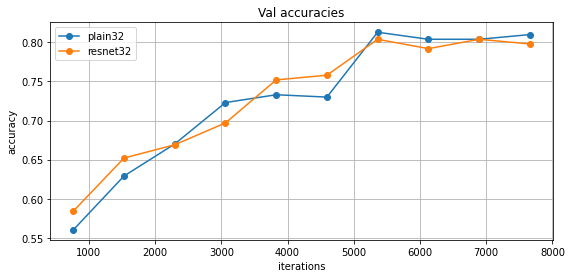

In [ ]:
plt.title('Val accuracies')
for name in names:
  plt.plot(iter_history_dict[name], acc_history_dict[name], '-o')
plt.legend(names, loc='upper left')
plt.xlabel('iterations')
plt.ylabel('accuracy')
plt.gcf().set_size_inches(9, 4)
plt.grid()
plt.show()

## Residual bottleneck block

A bottleneck block is often useful for better efficiency, especially when importing a model to mobile devices.
The residual bottleneck block is similar to the standard residual block, but the plain block part has a different architecture:
it consists of 3 convolutional layers, and the first two convolutional layers have a smaller number of channels.

Here is the specification of the bottleneck block:

1. Spatial Batch normalization
2. ReLU
3. Convolutional layer with `Cout // 4` 1x1 filters, stride 2 if downsampling; otherwise stride 1
4. Spatial Batch normalization
5. ReLU
6. Convolutional layer with `Cout // 4` 3x3 filters, with zero-padding of 1
7. Spatial Batch normalization
8. ReLU
9. Convolutional layer with `Cout` 1x1 filters

Don't forget to add the residual connection!

In [ ]:
class ResidualBottleneckBlock(nn.Module):
  def __init__(self, Cin, Cout, downsample=False):
    super().__init__()

    self.block = None
    self.shortcut = None
    ############################################################################
    # TODO: Implement residual bottleneck block.                               #
    # Inputs:                                                                  #
    # - Cin: number of input channels                                          #
    # - Cout: number of output channels                                        #
    # - downsample: add downsampling (a conv with stride=2) if True            #
    # Store the main block in self.block and the shortcut in self.shortcut.    #
    ############################################################################
    # Replace "pass" statement with your code
    if Cin == Cout and not downsample:
        self.block = nn.Sequential(
            nn.BatchNorm2d(Cin),
            nn.ReLU(),
            nn.Conv2d(Cin, Cout//4, (1, 1), stride=1, padding=0),
            nn.BatchNorm2d(Cout//4),
            nn.ReLU(),
            nn.Conv2d(Cout//4, Cout//4, (3, 3), stride=1, padding=1),
            nn.BatchNorm2d(Cout//4),
            nn.ReLU(),
            nn.Conv2d(Cout//4, Cout, (1, 1), stride=1, padding=0)
        )
        self.shortcut = nn.Identity()
    elif Cin != Cout and not downsample:
        self.block = nn.Sequential(
            nn.BatchNorm2d(Cin),
            nn.ReLU(),
            nn.Conv2d(Cin, Cout//4, (1, 1), stride=1, padding=0),
            nn.BatchNorm2d(Cout//4),
            nn.ReLU(),
            nn.Conv2d(Cout//4, Cout//4, (3, 3), stride=1, padding=1),
            nn.BatchNorm2d(Cout//4),
            nn.ReLU(),
            nn.Conv2d(Cout//4, Cout, (1, 1), stride=1, padding=0)
        )
        self.shortcut = nn.Conv2d(Cin, Cout, (1, 1), stride=1, padding=0, bias=False)
    elif downsample:
        self.block = nn.Sequential(
            nn.BatchNorm2d(Cin),
            nn.ReLU(),
            nn.Conv2d(Cin, Cout//4, (1, 1), stride=2, padding=0),
            nn.BatchNorm2d(Cout//4),
            nn.ReLU(),
            nn.Conv2d(Cout//4, Cout//4, (3, 3), stride=1, padding=1),
            nn.BatchNorm2d(Cout//4),
            nn.ReLU(),
            nn.Conv2d(Cout//4, Cout, (1, 1), stride=1, padding=0)
        )
        self.shortcut = nn.Conv2d(Cin, Cout, (1, 1), stride=2, padding=0, bias=False)
    ############################################################################
    #                                 END OF YOUR CODE                         #
    ############################################################################

  def forward(self, x):
    return self.block(x) + self.shortcut(x)

In [ ]:
data = torch.zeros(2, 3, 5, 6)
model = ResidualBottleneckBlock(3, 10)
if list(model(data).shape) == [2, 10, 5, 6]:
  print('The output of ResidualBlock without downsampling has a *correct* dimension!')
else:
  print('The output of ResidualBlock without downsampling has an *incorrect* dimension! expected:', [2, 10, 5, 6], 'got:', list(model(data).shape))

data = torch.zeros(2, 3, 5, 6)
model = ResidualBottleneckBlock(3, 10, downsample=True)
if list(model(data).shape) == [2, 10, 3, 3]:
  print('The output of ResidualBlock with downsampling has a *correct* dimension!')
else:
  print('The output of ResidualBlock with downsampling has an *incorrect* dimension! expected:', [2, 10, 3, 3], 'got:', list(model(data).shape))

The output of ResidualBlock without downsampling has a *correct* dimension!
The output of ResidualBlock with downsampling has a *correct* dimension!


By running the following script, you can check the architecture of ResNet-47 with bottlenecks.

Caution: it is long!

In [ ]:
# example of specification
networks.update({
  'resnet47': {
    'block': ResidualBottleneckBlock,
    'stage_args': [
      (32, 32, 5, False),
      (32, 64, 5, True),
      (64, 128, 5, True),
    ],
  },
})

print(get_resnet('resnet47'))

ResNet(
  (cnn): Sequential(
    (0): ResNetStem(
      (net): Sequential(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
      )
    )
    (1): ResNetStage(
      (net): Sequential(
        (0): ResidualBlock(
          (block): Sequential(
            (0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (1): ReLU()
            (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (4): ReLU()
            (5): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
          (shortcut): Identity()
        )
        (1): ResidualBlock(
          (block): Sequential(
            (0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (1): ReLU()
            (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1

# The following is supplementary content.

In [ ]:
names = ['plain32', 'resnet32', 'resnet47']
acc_history_dict = {}
iter_history_dict = {}
for name in names:
  fix_random_seed(0)
  print(name, '\n')
  model = get_resnet(name)
#   init_module(model)
  
  optimizer = optim.SGD(model.parameters(), lr=1e-2, momentum=.9, weight_decay=1e-4)

  acc_history, iter_history = train(model, optimizer, epochs=10, schedule=[6, 8], verbose=False)
  acc_history_dict[name] = acc_history
  iter_history_dict[name] = iter_history

plain32 

Epoch 0, Iteration 765, loss = 1.0970
Checking accuracy on validation set
Got 561 / 1000 correct (56.10)

Epoch 1, Iteration 1531, loss = 1.0507
Checking accuracy on validation set
Got 609 / 1000 correct (60.90)

Epoch 2, Iteration 2297, loss = 0.7023
Checking accuracy on validation set
Got 638 / 1000 correct (63.80)

Epoch 3, Iteration 3063, loss = 0.7893
Checking accuracy on validation set
Got 692 / 1000 correct (69.20)

Epoch 4, Iteration 3829, loss = 0.5318
Checking accuracy on validation set
Got 717 / 1000 correct (71.70)

Epoch 5, Iteration 4595, loss = 1.1159
Checking accuracy on validation set
Got 733 / 1000 correct (73.30)

lr decay from 0.01 to 0.001
Epoch 6, Iteration 5361, loss = 0.5287
Checking accuracy on validation set
Got 801 / 1000 correct (80.10)

Epoch 7, Iteration 6127, loss = 0.6134
Checking accuracy on validation set
Got 793 / 1000 correct (79.30)

lr decay from 0.001 to 0.0001
Epoch 8, Iteration 6893, loss = 0.2973
Checking accuracy on validation set
Go

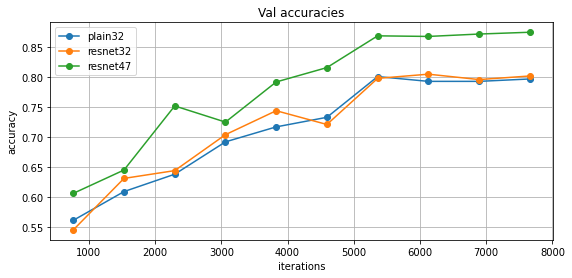

In [ ]:
plt.title('Val accuracies')
for name in names:
  plt.plot(iter_history_dict[name], acc_history_dict[name], '-o')
plt.legend(names, loc='upper left')
plt.xlabel('iterations')
plt.ylabel('accuracy')
plt.gcf().set_size_inches(9, 4)
plt.grid()
plt.show()

In [ ]:
# Model summary
from torchsummary import summary

summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
        ResNetStem-3           [-1, 32, 32, 32]               0
       BatchNorm2d-4           [-1, 32, 32, 32]              64
              ReLU-5           [-1, 32, 32, 32]               0
            Conv2d-6           [-1, 32, 32, 32]           9,248
       BatchNorm2d-7           [-1, 32, 32, 32]              64
              ReLU-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 32, 32, 32]           9,248
         Identity-10           [-1, 32, 32, 32]               0
    ResidualBlock-11           [-1, 32, 32, 32]               0
      BatchNorm2d-12           [-1, 32, 32, 32]              64
             ReLU-13           [-1, 32, 32, 32]               0
           Conv2d-14           [-1, 32,

*Many thanks to Justin Johnson and Stanford CS231n for permission to use their materials!*